# 0. Importing libraries and setting up

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import rasterio
from rasterio.plot import show as rasterio_show
import rasterstats
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from warnings import simplefilter
import re
import json
import joblib
from rasterio.transform import from_origin
import os

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=UserWarning)

In [3]:
TRAIN_PATH = "data/datasets/Train.gpkg" # 1 = landslide, 0 = no landslide; 1:10000 scale
TEST_PATH = "data/datasets/Test.gpkg"
ROAD_PATH = "data/datasets/road_network.gpkg" # 1:10000 scale
RIVER_PATH = "data/datasets/river_network.gpkg" # 1:10000 scale
FAULT_PATH = "data/datasets/geological_faults.gpkg" # 1:10000 scale
LANDUSE_PATH = "data/datasets/land_use_land_cover.gpkg" # 1:10000 scale

TERRAIN_PATH = "data/datasets/dtm.tif" # 5m/pixel scale
PRECIPITATION_AVERAGE_PATH = "data/datasets/average_precipitation_2020.tif"
PRECIPITATION_90_PATH = "data/datasets/90_perc_precipitation_2020.tif"

# 1. Exploring training data

We can start by loading the train dataframe and all of the geodataframes that we'll use as features and also plotting them so that we can explore how the data is spatially distributed and also what are the columns present in each geodataframe:

In [4]:
gdf_train = gpd.read_file(TRAIN_PATH)
gdf_test = gpd.read_file(TEST_PATH)
gdf_road = gpd.read_file(ROAD_PATH)
gdf_river = gpd.read_file(RIVER_PATH)
gdf_fault = gpd.read_file(FAULT_PATH)
gdf_landuse = gpd.read_file(LANDUSE_PATH)

We can first look at how the training data looks like and how it is geographically distributed:

In [5]:
#gdf_train.explore(column="Target", popup=True, categorical=True, cmap="rainbow")

In [6]:
gdf_train.head()

,Target,ID,geometry
0,1,ID_000001,"MULTIPOLYGON (((607152.916 5124458.395, 607137..."
1,1,ID_000002,"MULTIPOLYGON (((611957.101 5131543.071, 611970..."
2,1,ID_000003,"MULTIPOLYGON (((612895.966 5130875.565, 612880..."
3,1,ID_000004,"MULTIPOLYGON (((609366.882 5131249.149, 609361..."
4,1,ID_000005,"MULTIPOLYGON (((611814.848 5132646.039, 611808..."


Notice that we have geometries of type `MULTIPOLYGON`, but if we check the test data:

In [7]:
gdf_test.head()

,ID,geometry
0,ID_000001,POINT (541862.336 5103652.266)
1,ID_000002,POINT (566456.496 5131798.978)
2,ID_000003,POINT (584598.972 5109016.391)
3,ID_000004,POINT (542414.162 5125941.301)
4,ID_000005,POINT (532099.144 5133370.588)


We have `POINT` geometries. This is problematic due to the shift between the very nature of the training and test data. There are many ways that we could remedy this, but I'll just be considering the training geometry to be centroids of the current geometry in order to have `POINT`s:

In [8]:
gdf_train.geometry = gdf_train.centroid
gdf_train.head()

,Target,ID,geometry
0,1,ID_000001,POINT (607174.077 5124482.765)
1,1,ID_000002,POINT (611796.308 5131481.270)
2,1,ID_000003,POINT (613139.607 5131228.879)
3,1,ID_000004,POINT (609347.488 5131305.222)
4,1,ID_000005,POINT (611761.133 5132712.759)


Now with this fixed we can explore the feature geodataframes:

In [9]:
#gdf_road.explore(column="Type", popup=True, cmap="rainbow")

In [10]:
#gdf_river.explore(column="Area_Protetta", popup=True, cmap="rainbow")

In [11]:
#gdf_fault.explore(column="DTIPO_EL", popup=True, cmap="rainbow")

In [12]:
#gdf_landuse.explore(column="2-DESCRIZIONE", popup=True, cmap="rainbow")

# 2. Preprocessing data

# 2.1 Cleaning the features

The geodataframes that we can use as features (road, river, geological fault and land use data) contain a lot of columns. Some of them are either not relevant or entirely redundant. So let's take a look at some of our geodataframes!

### 2.1.1 Road data

We can start with the road data:

In [13]:
gdf_road.head()

,OBJECTID,Type,geometry
0,1,Provincial,"MULTILINESTRING ((534339.256 5118601.006, 5343..."
1,2,Provincial,"MULTILINESTRING ((551170.852 5113444.592, 5511..."
2,3,Provincial,"MULTILINESTRING ((539150.584 5110916.961, 5391..."
3,4,Provincial,"MULTILINESTRING ((566947.991 5113592.533, 5669..."
4,5,Provincial,"MULTILINESTRING ((540942.996 5110424.239, 5409..."


It has only one feature, `Type`, we can check to see how it is distributed:

In [14]:
gdf_road["Type"].value_counts(dropna=False)

Type
Secondary     2608
Provincial     225
Name: count, dtype: int64

Though the distribution is imbalanced, we can keep this feature as it is really important when it comes to determining the type of road we're dealing with.

For cleaning purposes, we can remove `OBJECTID`:

In [15]:
gdf_road = gdf_road.drop("OBJECTID", axis=1)
gdf_road.head()

,Type,geometry
0,Provincial,"MULTILINESTRING ((534339.256 5118601.006, 5343..."
1,Provincial,"MULTILINESTRING ((551170.852 5113444.592, 5511..."
2,Provincial,"MULTILINESTRING ((539150.584 5110916.961, 5391..."
3,Provincial,"MULTILINESTRING ((566947.991 5113592.533, 5669..."
4,Provincial,"MULTILINESTRING ((540942.996 5110424.239, 5409..."


Finally, to make everything clearer, we can rename the `Type` column:

In [16]:
gdf_road = gdf_road.rename(columns={"Type": "road_type"})
gdf_road.head()

,road_type,geometry
0,Provincial,"MULTILINESTRING ((534339.256 5118601.006, 5343..."
1,Provincial,"MULTILINESTRING ((551170.852 5113444.592, 5511..."
2,Provincial,"MULTILINESTRING ((539150.584 5110916.961, 5391..."
3,Provincial,"MULTILINESTRING ((566947.991 5113592.533, 5669..."
4,Provincial,"MULTILINESTRING ((540942.996 5110424.239, 5409..."


### 2.1.2 River data

There's a lot of info on the river data:

In [17]:
print("columns:", gdf_river.columns)
gdf_river.head()

columns: Index(['Objectid', 'COD_PTUA16', 'Natura_Corpo_Idrico', 'Regione',
       'Nome_Corpo_Idrico', 'Sottobacino', 'Tipologia', 'Area_Protetta',
       'Area_Sensibile', 'Zona_Vulnerabile_Nitrati', 'Direttiva_Habitat',
       'Direttiva_Uccelli', 'Ramsar', 'Balneazione', 'Vita_Pesci',
       'Area_Uso_Potabile', 'Altre_Aree_Protette', 'Bacino',
       'Raggruppamento_ecologico', 'Raggruppamento_chimico', 'Stato_ecologico',
       'Confidenza_SE', 'Stato_chimico', 'Confidenza_SC',
       'Anni_classificazione_chimica', 'Anni_classificazione_ecologica',
       'Obiettivo_chimico', 'Obiettivo_ecologico',
       'Proroghe_Deroghe_Obiettivi', 'Shape_Length', 'geometry'],
      dtype='object')


,Objectid,COD_PTUA16,Natura_Corpo_Idrico,Regione,Nome_Corpo_Idrico,Sottobacino,Tipologia,Area_Protetta,Area_Sensibile,Zona_Vulnerabile_Nitrati,...,Confidenza_SE,Stato_chimico,Confidenza_SC,Anni_classificazione_chimica,Anni_classificazione_ecologica,Obiettivo_chimico,Obiettivo_ecologico,Proroghe_Deroghe_Obiettivi,Shape_Length,geometry
0,80,IT03N0080011181LO,naturale,Lombardia,Bocco (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,...,bassa,buono,media,2009-2014,2009-2014,mantenimento dello stato buono,buono al 2021,Art. 4.4 per obiettivo ecologico,6299.737674,"MULTILINESTRING ((560632.026 5117681.015, 5606..."
1,81,IT03N0080011191LO,naturale,Lombardia,Caldenno (Torrente),Adda Sopra Lacuale,03SS1N,sì,no,no,...,media,buono,bassa,2009-2014,2009-2014,mantenimento dello stato buono,mantenimento dello stato buono,Nessuna proroga o deroga,10048.606396,"MULTILINESTRING ((558726.924 5117476.246, 5587..."
2,83,IT03N0080011201LO,naturale,Lombardia,Cervio (Torrente),Adda Sopra Lacuale,03SS1N,sì,no,no,...,media,buono,bassa,2009-2014,2009-2014,mantenimento dello stato buono,mantenimento dello stato buono,Nessuna proroga o deroga,12935.464798,"MULTILINESTRING ((561401.514 5103620.664, 5614..."
3,84,IT03N0080011211LO,naturale,Lombardia,Finale (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,...,NaN,NC,NaN,2014,2014,buono al 2021,buono al 2021,Art. 4.4 per obiettivo ecologico e chimico,7468.679791,"MULTILINESTRING ((557362.171 5117885.840, 5573..."
4,85,IT03N0080011251LO,naturale,Lombardia,Maroggia (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,...,bassa,buono,media,2009-2014,2009-2014,mantenimento dello stato buono,buono al 2021,Art. 4.4 per obiettivo ecologico,6140.976728,"MULTILINESTRING ((554178.901 5113356.588, 5541..."


We can start by checking if there are any columns with only one value:

In [18]:
for col in gdf_river.columns:
    print(col, gdf_river[col].nunique())

Objectid 115
COD_PTUA16 115
Natura_Corpo_Idrico 1
Regione 1
Nome_Corpo_Idrico 96
Sottobacino 6
Tipologia 4
Area_Protetta 2
Area_Sensibile 2
Zona_Vulnerabile_Nitrati 1
Direttiva_Habitat 2
Direttiva_Uccelli 2
Ramsar 2
Balneazione 1
Vita_Pesci 2
Area_Uso_Potabile 2
Altre_Aree_Protette 2
Bacino 4
Raggruppamento_ecologico 2
Raggruppamento_chimico 2
Stato_ecologico 4
Confidenza_SE 4
Stato_chimico 3
Confidenza_SC 4
Anni_classificazione_chimica 3
Anni_classificazione_ecologica 3
Obiettivo_chimico 2
Obiettivo_ecologico 2
Proroghe_Deroghe_Obiettivi 4
Shape_Length 115
geometry 115


And we already found some cases where that is the case, let's drop them and also id columns:

In [19]:
# redundant features
gdf_river = gdf_river.drop("Natura_Corpo_Idrico", axis=1)
gdf_river = gdf_river.drop("Regione", axis=1)
gdf_river = gdf_river.drop("Zona_Vulnerabile_Nitrati", axis=1)
gdf_river = gdf_river.drop("Balneazione", axis=1)

# id columns
gdf_river = gdf_river.drop("Objectid", axis=1)
gdf_river = gdf_river.drop("COD_PTUA16", axis=1)

gdf_river.head()

,Nome_Corpo_Idrico,Sottobacino,Tipologia,Area_Protetta,Area_Sensibile,Direttiva_Habitat,Direttiva_Uccelli,Ramsar,Vita_Pesci,Area_Uso_Potabile,...,Confidenza_SE,Stato_chimico,Confidenza_SC,Anni_classificazione_chimica,Anni_classificazione_ecologica,Obiettivo_chimico,Obiettivo_ecologico,Proroghe_Deroghe_Obiettivi,Shape_Length,geometry
0,Bocco (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,bassa,buono,media,2009-2014,2009-2014,mantenimento dello stato buono,buono al 2021,Art. 4.4 per obiettivo ecologico,6299.737674,"MULTILINESTRING ((560632.026 5117681.015, 5606..."
1,Caldenno (Torrente),Adda Sopra Lacuale,03SS1N,sì,no,no,no,no,no,no,...,media,buono,bassa,2009-2014,2009-2014,mantenimento dello stato buono,mantenimento dello stato buono,Nessuna proroga o deroga,10048.606396,"MULTILINESTRING ((558726.924 5117476.246, 5587..."
2,Cervio (Torrente),Adda Sopra Lacuale,03SS1N,sì,no,sì,sì,no,no,no,...,media,buono,bassa,2009-2014,2009-2014,mantenimento dello stato buono,mantenimento dello stato buono,Nessuna proroga o deroga,12935.464798,"MULTILINESTRING ((561401.514 5103620.664, 5614..."
3,Finale (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,NaN,NC,NaN,2014,2014,buono al 2021,buono al 2021,Art. 4.4 per obiettivo ecologico e chimico,7468.679791,"MULTILINESTRING ((557362.171 5117885.840, 5573..."
4,Maroggia (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,bassa,buono,media,2009-2014,2009-2014,mantenimento dello stato buono,buono al 2021,Art. 4.4 per obiettivo ecologico,6140.976728,"MULTILINESTRING ((554178.901 5113356.588, 5541..."


Some of these columns would be useful in case we had a more diverse set of "water data", like if we considered rivers from other regions or non-natural rivers.

Now let's see if we have repeating columns. We initially can check the cases where there are only two values:

In [20]:
print("=== 2 distinct values ===")
print(gdf_river["Area_Protetta"].value_counts(dropna=False))
print(gdf_river["Area_Sensibile"].value_counts(dropna=False))
print(gdf_river["Direttiva_Habitat"].value_counts(dropna=False))
print(gdf_river["Direttiva_Uccelli"].value_counts(dropna=False))
print(gdf_river["Ramsar"].value_counts(dropna=False))
print(gdf_river["Vita_Pesci"].value_counts(dropna=False))
print(gdf_river["Area_Uso_Potabile"].value_counts(dropna=False))
print(gdf_river["Altre_Aree_Protette"].value_counts(dropna=False))
print(gdf_river["Raggruppamento_ecologico"].value_counts(dropna=False))
print(gdf_river["Raggruppamento_chimico"].value_counts(dropna=False))
print(gdf_river["Obiettivo_chimico"].value_counts(dropna=False))
print(gdf_river["Obiettivo_ecologico"].value_counts(dropna=False))

=== 2 distinct values ===
Area_Protetta
sì    75
no    40
Name: count, dtype: int64
Area_Sensibile
no    107
sì      8
Name: count, dtype: int64
Direttiva_Habitat
no    62
sì    53
Name: count, dtype: int64
Direttiva_Uccelli
no    61
sì    54
Name: count, dtype: int64
Ramsar
no    113
sì      2
Name: count, dtype: int64
Vita_Pesci
no    111
sì      4
Name: count, dtype: int64
Area_Uso_Potabile
no    113
sì      2
Name: count, dtype: int64
Altre_Aree_Protette
no    103
sì     12
Name: count, dtype: int64
Raggruppamento_ecologico
sì     67
no     46
NaN     2
Name: count, dtype: int64
Raggruppamento_chimico
sì     67
no     46
NaN     2
Name: count, dtype: int64
Obiettivo_chimico
mantenimento dello stato buono    90
buono al 2021                     25
Name: count, dtype: int64
Obiettivo_ecologico
buono al 2021                     66
mantenimento dello stato buono    49
Name: count, dtype: int64


Out of these, `Ramsar` (with `Area_Uso_Potabile`) and `Raggruppamento_chimico` (with `Raggruppamento_ecologico`) have the same values, so we can drop them:

In [21]:
gdf_river = gdf_river.drop("Ramsar", axis=1)
gdf_river = gdf_river.drop("Raggruppamento_chimico", axis=1)
gdf_river.head()

,Nome_Corpo_Idrico,Sottobacino,Tipologia,Area_Protetta,Area_Sensibile,Direttiva_Habitat,Direttiva_Uccelli,Vita_Pesci,Area_Uso_Potabile,Altre_Aree_Protette,...,Confidenza_SE,Stato_chimico,Confidenza_SC,Anni_classificazione_chimica,Anni_classificazione_ecologica,Obiettivo_chimico,Obiettivo_ecologico,Proroghe_Deroghe_Obiettivi,Shape_Length,geometry
0,Bocco (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,bassa,buono,media,2009-2014,2009-2014,mantenimento dello stato buono,buono al 2021,Art. 4.4 per obiettivo ecologico,6299.737674,"MULTILINESTRING ((560632.026 5117681.015, 5606..."
1,Caldenno (Torrente),Adda Sopra Lacuale,03SS1N,sì,no,no,no,no,no,sì,...,media,buono,bassa,2009-2014,2009-2014,mantenimento dello stato buono,mantenimento dello stato buono,Nessuna proroga o deroga,10048.606396,"MULTILINESTRING ((558726.924 5117476.246, 5587..."
2,Cervio (Torrente),Adda Sopra Lacuale,03SS1N,sì,no,sì,sì,no,no,no,...,media,buono,bassa,2009-2014,2009-2014,mantenimento dello stato buono,mantenimento dello stato buono,Nessuna proroga o deroga,12935.464798,"MULTILINESTRING ((561401.514 5103620.664, 5614..."
3,Finale (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,NaN,NC,NaN,2014,2014,buono al 2021,buono al 2021,Art. 4.4 per obiettivo ecologico e chimico,7468.679791,"MULTILINESTRING ((557362.171 5117885.840, 5573..."
4,Maroggia (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,bassa,buono,media,2009-2014,2009-2014,mantenimento dello stato buono,buono al 2021,Art. 4.4 per obiettivo ecologico,6140.976728,"MULTILINESTRING ((554178.901 5113356.588, 5541..."


We can change the `NaN` values into an "unknown" category:

In [22]:
gdf_river["Raggruppamento_ecologico"] = gdf_river["Raggruppamento_ecologico"].fillna("unk")
gdf_river["Raggruppamento_ecologico"].value_counts(dropna=False)

Raggruppamento_ecologico
sì     67
no     46
unk     2
Name: count, dtype: int64

Now we can check the cases with 3 values:

In [23]:
print("=== 3 distinct values ===")
print(gdf_river["Stato_chimico"].value_counts(dropna=False))
print(gdf_river["Anni_classificazione_chimica"].value_counts(dropna=False))
print(gdf_river["Anni_classificazione_ecologica"].value_counts(dropna=False))

=== 3 distinct values ===
Stato_chimico
buono        90
NC           17
non buono     8
Name: count, dtype: int64
Anni_classificazione_chimica
2009-2014    75
2014         21
2012-2014    14
NaN           5
Name: count, dtype: int64
Anni_classificazione_ecologica
2009-2014    78
2012-2014    17
2014         15
NaN           5
Name: count, dtype: int64


No redundancy! Let's replace `NaN`s:

In [24]:
gdf_river["Anni_classificazione_chimica"] = gdf_river["Anni_classificazione_chimica"].fillna("unk")
gdf_river["Anni_classificazione_ecologica"] = gdf_river["Anni_classificazione_ecologica"].fillna("unk")

print(gdf_river["Anni_classificazione_chimica"].value_counts(dropna=False))
print(gdf_river["Anni_classificazione_ecologica"].value_counts(dropna=False))

Anni_classificazione_chimica
2009-2014    75
2014         21
2012-2014    14
unk           5
Name: count, dtype: int64
Anni_classificazione_ecologica
2009-2014    78
2012-2014    17
2014         15
unk           5
Name: count, dtype: int64


Now let's check 4 values:

In [25]:
print("=== 4 distinct values ===")
print(gdf_river["Tipologia"].value_counts(dropna=False))
print(gdf_river["Bacino"].value_counts(dropna=False))
print(gdf_river["Stato_ecologico"].value_counts(dropna=False))
print(gdf_river["Confidenza_SE"].value_counts(dropna=False))
print(gdf_river["Confidenza_SC"].value_counts(dropna=False))
print(gdf_river["Proroghe_Deroghe_Obiettivi"].value_counts(dropna=False))

=== 4 distinct values ===
Tipologia
03SS1N    66
03SS2N    23
03GH6N    22
03SS3N     4
Name: count, dtype: int64
Bacino
ADDA           106
SPOL             4
OGLIO            4
RENO DI LEI      1
Name: count, dtype: int64
Stato_ecologico
sufficiente    49
buono          47
NC             17
elevato         2
Name: count, dtype: int64
Confidenza_SE
media           45
bassa           43
NaN             17
alta             9
non definita     1
Name: count, dtype: int64
Confidenza_SC
bassa           36
alta            35
media           26
NaN             17
non definita     1
Name: count, dtype: int64
Proroghe_Deroghe_Obiettivi
Art. 4.4 per obiettivo ecologico              46
Nessuna proroga o deroga                      44
Art. 4.4 per obiettivo ecologico e chimico    20
Art. 4.4 per obiettivo chimico                 5
Name: count, dtype: int64


And again, no repeating columns! We just need to fill the `NaN`s:

In [26]:
gdf_river["Confidenza_SE"] = gdf_river["Confidenza_SE"].fillna("unk")
gdf_river["Confidenza_SC"] = gdf_river["Confidenza_SC"].fillna("unk")

print(gdf_river["Confidenza_SE"].value_counts(dropna=False))
print(gdf_river["Confidenza_SC"].value_counts(dropna=False))

Confidenza_SE
media           45
bassa           43
unk             17
alta             9
non definita     1
Name: count, dtype: int64
Confidenza_SC
bassa           36
alta            35
media           26
unk             17
non definita     1
Name: count, dtype: int64


Now as a last step we can rename the columns:

In [27]:
gdf_river = gdf_river.rename(columns={i: f"river_{i}" for i in gdf_river.columns[:-1]})
gdf_river.head()

,river_Nome_Corpo_Idrico,river_Sottobacino,river_Tipologia,river_Area_Protetta,river_Area_Sensibile,river_Direttiva_Habitat,river_Direttiva_Uccelli,river_Vita_Pesci,river_Area_Uso_Potabile,river_Altre_Aree_Protette,...,river_Confidenza_SE,river_Stato_chimico,river_Confidenza_SC,river_Anni_classificazione_chimica,river_Anni_classificazione_ecologica,river_Obiettivo_chimico,river_Obiettivo_ecologico,river_Proroghe_Deroghe_Obiettivi,river_Shape_Length,geometry
0,Bocco (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,bassa,buono,media,2009-2014,2009-2014,mantenimento dello stato buono,buono al 2021,Art. 4.4 per obiettivo ecologico,6299.737674,"MULTILINESTRING ((560632.026 5117681.015, 5606..."
1,Caldenno (Torrente),Adda Sopra Lacuale,03SS1N,sì,no,no,no,no,no,sì,...,media,buono,bassa,2009-2014,2009-2014,mantenimento dello stato buono,mantenimento dello stato buono,Nessuna proroga o deroga,10048.606396,"MULTILINESTRING ((558726.924 5117476.246, 5587..."
2,Cervio (Torrente),Adda Sopra Lacuale,03SS1N,sì,no,sì,sì,no,no,no,...,media,buono,bassa,2009-2014,2009-2014,mantenimento dello stato buono,mantenimento dello stato buono,Nessuna proroga o deroga,12935.464798,"MULTILINESTRING ((561401.514 5103620.664, 5614..."
3,Finale (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,unk,NC,unk,2014,2014,buono al 2021,buono al 2021,Art. 4.4 per obiettivo ecologico e chimico,7468.679791,"MULTILINESTRING ((557362.171 5117885.840, 5573..."
4,Maroggia (Torrente),Adda Sopra Lacuale,03SS1N,no,no,no,no,no,no,no,...,bassa,buono,media,2009-2014,2009-2014,mantenimento dello stato buono,buono al 2021,Art. 4.4 per obiettivo ecologico,6140.976728,"MULTILINESTRING ((554178.901 5113356.588, 5541..."


### 2.1.3 Geological fault data

Now we can look at the geological fault data:

In [28]:
gdf_fault.head()

,STRATO,TIPO_EL,DTIPO_EL,TIPO_FAGLI,DTIPO_FAGL,SHAPE_LEN,geometry
0,LS,01,faglia,451,sicuro,2374.873783,"MULTILINESTRING ((612408.332 5134021.967, 6124..."
1,LS,01,faglia,451,sicuro,1863.792970,"MULTILINESTRING ((616450.536 5132409.403, 6164..."
2,LS,01,faglia,452,presunto,533.097933,"MULTILINESTRING ((618185.892 5131734.372, 6184..."
3,LS,01,faglia,451,sicuro,1243.355818,"MULTILINESTRING ((616533.665 5131699.423, 6165..."
4,LS,01,faglia,452,presunto,615.657716,"MULTILINESTRING ((617754.025 5131478.893, 6177..."


Let's take a look at the `STRATO` column:

In [29]:
gdf_fault["STRATO"].value_counts()

STRATO
LS    8328
Name: count, dtype: int64

We can see that this feature is redundant due to the fact that all of our data has the same `LS` type. We can remove it right away in order to clear the data a bit:

In [30]:
gdf_fault = gdf_fault.drop("STRATO", axis=1)
gdf_fault.head()

,TIPO_EL,DTIPO_EL,TIPO_FAGLI,DTIPO_FAGL,SHAPE_LEN,geometry
0,01,faglia,451,sicuro,2374.873783,"MULTILINESTRING ((612408.332 5134021.967, 6124..."
1,01,faglia,451,sicuro,1863.792970,"MULTILINESTRING ((616450.536 5132409.403, 6164..."
2,01,faglia,452,presunto,533.097933,"MULTILINESTRING ((618185.892 5131734.372, 6184..."
3,01,faglia,451,sicuro,1243.355818,"MULTILINESTRING ((616533.665 5131699.423, 6165..."
4,01,faglia,452,presunto,615.657716,"MULTILINESTRING ((617754.025 5131478.893, 6177..."


We already can notice that the columns with a `D` in front of them are probably a human-readable description of the equivalent columns without the `D`:

In [31]:
print("=== TIPO_EL ===")
print(gdf_fault["TIPO_EL"].value_counts(dropna=False))
print(gdf_fault["DTIPO_EL"].value_counts(dropna=False))

print("=== TIPO_FAGLI ===")
print(gdf_fault["TIPO_FAGLI"].value_counts(dropna=False))
print(gdf_fault["DTIPO_FAGL"].value_counts(dropna=False))

=== TIPO_EL ===
TIPO_EL
01    4009
02    3456
03     863
Name: count, dtype: int64
DTIPO_EL
faglia                 4009
frattura principale    3456
sovrascorrimento        863
Name: count, dtype: int64
=== TIPO_FAGLI ===
TIPO_FAGLI
NaN    3456
451    3226
452    1646
Name: count, dtype: int64
DTIPO_FAGL
NaN         3456
sicuro      3226
presunto    1646
Name: count, dtype: int64


Yep, exactly as expected! We can remove the encoded versions of the variable so that it is easier for us to understand what's going on AND to encode it back again without making any mistakes:

In [32]:
gdf_fault = gdf_fault.drop("TIPO_EL", axis=1)
gdf_fault = gdf_fault.drop("TIPO_FAGLI", axis=1)
gdf_fault.head()

,DTIPO_EL,DTIPO_FAGL,SHAPE_LEN,geometry
0,faglia,sicuro,2374.873783,"MULTILINESTRING ((612408.332 5134021.967, 6124..."
1,faglia,sicuro,1863.792970,"MULTILINESTRING ((616450.536 5132409.403, 6164..."
2,faglia,presunto,533.097933,"MULTILINESTRING ((618185.892 5131734.372, 6184..."
3,faglia,sicuro,1243.355818,"MULTILINESTRING ((616533.665 5131699.423, 6165..."
4,faglia,presunto,615.657716,"MULTILINESTRING ((617754.025 5131478.893, 6177..."


Replacing the `NaN` values:

In [33]:
gdf_fault["DTIPO_FAGL"] = gdf_fault["DTIPO_FAGL"].fillna("unk")
gdf_fault["DTIPO_FAGL"].value_counts(dropna=False)

DTIPO_FAGL
unk         3456
sicuro      3226
presunto    1646
Name: count, dtype: int64

And as a last step, rename the columns:

In [34]:
gdf_fault = gdf_fault.rename(columns={i: f"fault_{i}" for i in gdf_fault.columns[:-1]})
gdf_fault.head()

,fault_DTIPO_EL,fault_DTIPO_FAGL,fault_SHAPE_LEN,geometry
0,faglia,sicuro,2374.873783,"MULTILINESTRING ((612408.332 5134021.967, 6124..."
1,faglia,sicuro,1863.792970,"MULTILINESTRING ((616450.536 5132409.403, 6164..."
2,faglia,presunto,533.097933,"MULTILINESTRING ((618185.892 5131734.372, 6184..."
3,faglia,sicuro,1243.355818,"MULTILINESTRING ((616533.665 5131699.423, 6165..."
4,faglia,presunto,615.657716,"MULTILINESTRING ((617754.025 5131478.893, 6177..."


#### 2.1.4 Land use data

Let's look at land use:

In [35]:
gdf_landuse.head()

,2-CODICE,2-DESCRIZIONE,geometry
0,11,Urban areas,"MULTIPOLYGON (((586619.671 5110980.672, 586616..."
1,23,Permanent lawns,"MULTIPOLYGON (((584845.312 5112586.691, 584845..."
2,31,Forested areas,"MULTIPOLYGON (((586537.167 5112751.421, 586540..."
3,13,"Mining areas, landfills, construction sites, a...","MULTIPOLYGON (((584992.068 5112124.177, 584989..."
4,23,Permanent lawns,"MULTIPOLYGON (((585600.563 5113285.920, 585605..."


Looks like we have a similar situation to what we had in the geological fault data:

In [36]:
print(gdf_landuse["2-CODICE"].value_counts(dropna=False))
print(gdf_landuse["2-DESCRIZIONE"].value_counts(dropna=False))

2-CODICE
32     6661
33     6532
23     5672
31     4051
11     3083
22     1196
12     1054
51      937
21      888
14      325
13      215
41       53
NaN       5
Name: count, dtype: int64
2-DESCRIZIONE
Environments with evolving shrub and/or herbaceous vegetation                 6661
Open areas with sparse and absent vegetation                                  6532
Permanent lawns                                                               5672
Forested areas                                                                4051
Urban areas                                                                   3083
Permanent crops                                                               1196
Production sites, large plants and communication networks                     1054
Inland waters                                                                  937
Arable land                                                                    888
Non-agricultural green areas                    

Again, let's do what we did before and while we're at it let's remove the "2-" at the start of the description column:

In [37]:
gdf_landuse = gdf_landuse.drop("2-CODICE", axis=1).rename(columns={"2-DESCRIZIONE": "landuse_DESCRIZIONE"})
gdf_landuse.head()

,landuse_DESCRIZIONE,geometry
0,Urban areas,"MULTIPOLYGON (((586619.671 5110980.672, 586616..."
1,Permanent lawns,"MULTIPOLYGON (((584845.312 5112586.691, 584845..."
2,Forested areas,"MULTIPOLYGON (((586537.167 5112751.421, 586540..."
3,"Mining areas, landfills, construction sites, a...","MULTIPOLYGON (((584992.068 5112124.177, 584989..."
4,Permanent lawns,"MULTIPOLYGON (((585600.563 5113285.920, 585605..."


And replace the `NaN` values:

In [38]:
gdf_landuse["landuse_DESCRIZIONE"] = gdf_landuse["landuse_DESCRIZIONE"].fillna("unk")
gdf_landuse["landuse_DESCRIZIONE"].value_counts(dropna=False)

landuse_DESCRIZIONE
Environments with evolving shrub and/or herbaceous vegetation                 6661
Open areas with sparse and absent vegetation                                  6532
Permanent lawns                                                               5672
Forested areas                                                                4051
Urban areas                                                                   3083
Permanent crops                                                               1196
Production sites, large plants and communication networks                     1054
Inland waters                                                                  937
Arable land                                                                    888
Non-agricultural green areas                                                   325
Mining areas, landfills, construction sites, artificial and abandoned land     215
Indoor wet areas                                                   

Now our data is much cleaner and we dropped some redundant columns that could probably mess with our model!

# 2.2 Buffering

A big part of the training data is made from relatively small geometries, and given that we want to model landslide susceptibility, the information present directly WITHIN the geometry that we're considering might not be enough. For instance, the fact that there's a river 50 m away from the geometry we're analyzing might make it more susceptible to a landslide, even though the river isn't crossing directly thorough the geometry. Thus, it'd be a good idea to consider also what is near our geometry when joining our geodataframes.

We can use *buffering* as a way to enlarge our geometries by creating a buffer zone around them. Then, we can perform the join considering the buffer zone in order to capture what's around our geometries. The cool thing about buffering is that we can define the buffering radius in meters, which allows us to be very precise when considering this extra area of effect.

A demonstration of how buffering would be useful is available on the next plot:

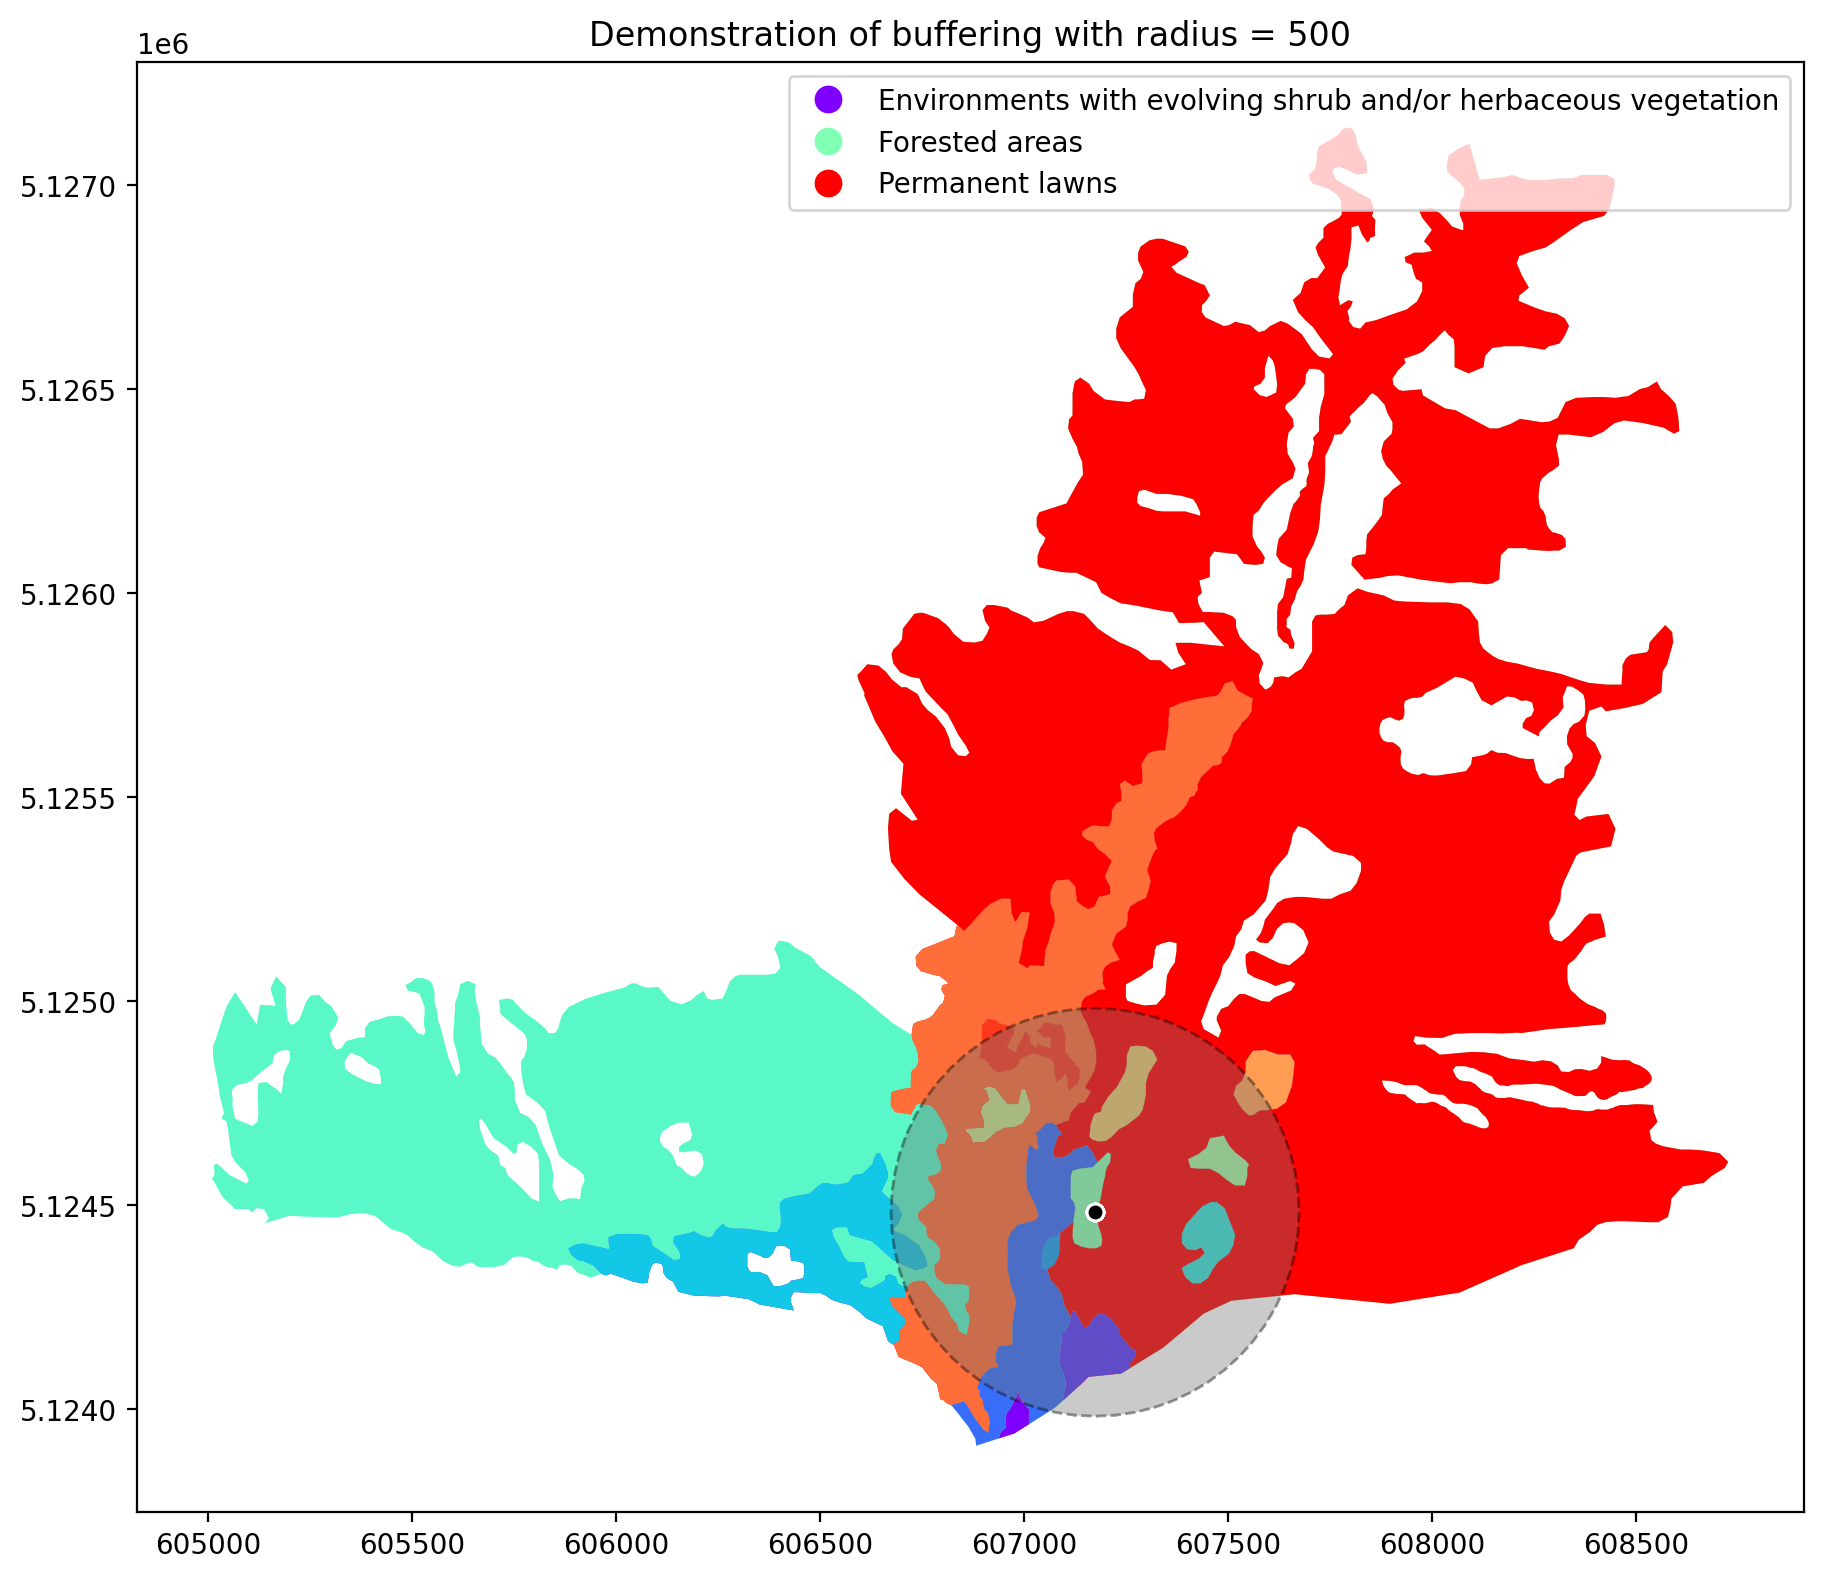

In [39]:
def demonstrate_buffering(gdf_train, gdf_other, gdf_other_label, radius=500):
    # copy only the first point on the training dataframe for demonstration purposes
    single_point = gdf_train.iloc[0:1].copy()
    
    # buffer the geometry by `radius` meters and then set buffered geometry as main geometry
    single_point[f"geometry_buffer_{radius}"] = single_point["geometry"].buffer(radius)
    single_point = single_point.set_geometry(f"geometry_buffer_{radius}")
    
    joined = single_point.sjoin(gdf_other, how="left", predicate="intersects")

    fig, ax = plt.subplots(figsize=(12,8), dpi=200)
    
    full = gdf_other.iloc[joined["index_right"]]
    full.plot(column=gdf_other_label, legend=True, cmap="rainbow", ax=ax)
    full.plot(cmap="rainbow", ax=ax)

    joined.plot(ax=ax, color="grey", alpha=0.03, linestyle="--", edgecolor="black")

    original = joined.set_geometry("geometry")
    original.plot(ax=ax, color="black", edgecolor="white")

    #legend = ax.get_legend()
    #legend.set_title(gdf_other_label)
    
    plt.title(f"Demonstration of buffering with radius = {radius}")
    
    plt.tight_layout()
    plt.show()
    
demonstrate_buffering(gdf_train, gdf_landuse, "landuse_DESCRIZIONE", radius=500)

Here, the black geometry with a white outline is the original geometry and the greyed area with a dashed line is the buffered geometry. The other parts of the plot are the geometries that intersect with the buffered geometry, with different colors symbolizing different geometry instances.

Note that in this single example we were already able to get a much better understanding of the area surrounding the geometry. We are able to access a wider area containing a more varied geography that most certainly affects what happens on the original geometry we're looking at. This demonstration uses the land use geodataframe, but buffering is also very useful for the detection of nearby roads, rivers and geographic faults.

The difference is that in order to calculate our features we'll be calculating the overlays instead of just doing spatial joins. If we look at our example, this means that instead of getting the full geometries of the areas that intersect with our point, we only get the areas of these geometries that are inside the greyed area. This will be useful for us later on in order to calculate features related to density and also in order to get a more refined measure of what is actually part of the buffered area. In this example, for instance, the inclusion of the entire cyan geometry on the left wouldn't make much sense given the fact that only a fraction of it is intersecting our buffer area; instead, we include the information of this geometry but only considering the smaller area in the intersection.

We also implement a function that allows us to calculate the distance between the points in our training geodataframe and the geometries from the feature geodataframes that intersect with the buffer areas:

In [40]:
def _calculate_distance_by_id(gdf_point, gdf_feature, feature_name, train):
    # merge the geodataframes on "ID" column
    merged_gdf = gdf_point[["ID", "geometry"]].merge(gdf_feature, on="ID", suffixes=("_point", "_feature"))

    # calculate the distance for each pair of point and feature geometries
    merged_gdf[f"{feature_name}_distance"] = merged_gdf.apply(
        lambda row: row['geometry_point'].distance(row['geometry_feature']), axis=1
    )

    # drop unnecessary columns from the merged geodataframe
    if train:
        cols_to_drop = ["geometry_point", "geometry_feature", "Target"]
    else:
        cols_to_drop = ["geometry_point", "geometry_feature"]
    
    merged_gdf = merged_gdf.drop(columns=cols_to_drop)

    return merged_gdf

Now we can prepare our data by using buffering:

In [41]:
def dataprep_buffer(data, buffer_radii, train):
    combined_list = []

    for radius in buffer_radii:
        print(f"preparing geodataframe for radius {radius}...")
        
        # buffer geodataframe and set buffered geometry as main geometry
        buffered = data.copy()
        
        buffered[f"geometry_buffer_radius{radius}"] = buffered["geometry"].buffer(radius)
        buffered = buffered.set_geometry(f"geometry_buffer_radius{radius}")
        
        # perform overlays to find intersections
        train_road = gpd.overlay(buffered, gdf_road, how="intersection", keep_geom_type=False)
        train_river = gpd.overlay(buffered, gdf_river, how="intersection", keep_geom_type=False)
        train_fault = gpd.overlay(buffered, gdf_fault, how="intersection", keep_geom_type=False)
        train_landuse = gpd.overlay(buffered, gdf_landuse, how="intersection", keep_geom_type=False)
        
        # get overlay intersection area and length
        train_road["road_intersection_length"] = train_road.length
        train_river["river_intersection_length"] = train_river.length
        train_fault["fault_intersection_length"] = train_fault.length
        train_landuse["landuse_intersection_length"] = train_landuse.length
        train_landuse["landuse_intersection_area"] = train_landuse.area
        
        # get some buffered geometry characteristics
        buffered[f"area_buffer_radius{radius}"] = buffered.area
        buffered[f"length_buffer_radius{radius}"] = buffered.length
        
        # reset geometry
        buffered = buffered.set_geometry("geometry")
        
        # remove buffered geometry column
        buffered = buffered.drop(f"geometry_buffer_radius{radius}", axis=1)
        
        # get distance from centroids to the intersected geometries
        train_road = _calculate_distance_by_id(buffered, train_road, "road", train)
        train_river = _calculate_distance_by_id(buffered, train_river, "river", train)
        train_fault = _calculate_distance_by_id(buffered, train_fault, "fault", train)
        train_landuse = _calculate_distance_by_id(buffered, train_landuse, "landuse", train)
        
        # rename columns from overlay to contain the radius (so that we can merge everything into a big dataframe later)
        train_road = train_road.rename(columns={i: f"{i}_radius{radius}" for i in list(train_road.columns) if i != "ID"})
        train_river = train_river.rename(columns={i: f"{i}_radius{radius}" for i in list(train_river.columns) if i != "ID"})
        train_fault = train_fault.rename(columns={i: f"{i}_radius{radius}" for i in list(train_fault.columns) if i != "ID"})
        train_landuse = train_landuse.rename(columns={i: f"{i}_radius{radius}" for i in list(train_landuse.columns) if i != "ID"})
        
        # concatenate all of the geodataframes
        combined = pd.concat([buffered, train_road, train_river, train_fault, train_landuse])
        combined_list.append(combined)
    
    # get big dataframe with every buffer radius
    df = pd.concat(combined_list)
    
    return df


buffer_radii = [100, 500, 1000, 2500] # in meters

df_train_prepped = dataprep_buffer(gdf_train, buffer_radii, train=True)

preparing geodataframe for radius 100...


preparing geodataframe for radius 500...
preparing geodataframe for radius 1000...
preparing geodataframe for radius 2500...


We can take a look at our dataframe:

In [42]:
print(df_train_prepped.shape)
df_train_prepped.head()

(3753563, 155)


,Target,ID,geometry,area_buffer_radius100,length_buffer_radius100,road_type_radius100,road_intersection_length_radius100,road_distance_radius100,river_Nome_Corpo_Idrico_radius100,river_Sottobacino_radius100,...,river_distance_radius2500,fault_DTIPO_EL_radius2500,fault_DTIPO_FAGL_radius2500,fault_SHAPE_LEN_radius2500,fault_intersection_length_radius2500,fault_distance_radius2500,landuse_DESCRIZIONE_radius2500,landuse_intersection_length_radius2500,landuse_intersection_area_radius2500,landuse_distance_radius2500
0,1.0,ID_000001,POINT (607174.077 5124482.765),31365.484905,628.066231,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,ID_000002,POINT (611796.308 5131481.270),31365.484905,628.066231,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,ID_000003,POINT (613139.607 5131228.879),31365.484905,628.066231,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,ID_000004,POINT (609347.488 5131305.222),31365.484905,628.066231,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,ID_000005,POINT (611761.133 5132712.759),31365.484905,628.066231,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is gigantic! Now in order to put everything back to its place we need to perform a group by operation using the `ID`. And we'll be using an aggregate function to turn all of the other columns (except for the `Target` and the `geometry`) into lists. This will allow us to process the lists, creating the features we may need to use in our model:

In [43]:
def dataprep_group(data, train):
    # define the columns we'll use for the group by operation
    if train:
        grouped_cols = {"Target": "first", "ID": "first", "geometry": "first"}
        grouped_cols.update({i: list for i in data.columns if i not in ["Target", "ID", "geometry"]})
    
    else:
        grouped_cols = {"ID": "first", "geometry": "first"}
        grouped_cols.update({i: list for i in data.columns if i not in ["ID", "geometry"]})
    
    # group data
    grouped = data.groupby("ID").agg(grouped_cols)
    
    return grouped

df_train_prepped = dataprep_group(df_train_prepped, train=True)

And this will leave us with:

In [44]:
print(df_train_prepped.shape)
df_train_prepped.head()

(12140, 155)


,Target,ID,geometry,area_buffer_radius100,length_buffer_radius100,road_type_radius100,road_intersection_length_radius100,road_distance_radius100,river_Nome_Corpo_Idrico_radius100,river_Sottobacino_radius100,...,river_distance_radius2500,fault_DTIPO_EL_radius2500,fault_DTIPO_FAGL_radius2500,fault_SHAPE_LEN_radius2500,fault_intersection_length_radius2500,fault_distance_radius2500,landuse_DESCRIZIONE_radius2500,landuse_intersection_length_radius2500,landuse_intersection_area_radius2500,landuse_distance_radius2500
ID,,,,,,,,,,,,,,,,,,,,,
ID_000001,1.0,ID_000001,POINT (607174.077 5124482.765),"[31365.484905395606, nan, nan, nan, nan, nan, ...","[628.0662313903119, nan, nan, nan, nan, nan, n...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, Val Grande (Torrente), nan, nan, nan, na...","[nan, Oglio Sopra Lacuale, nan, nan, nan, nan,...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
ID_000002,1.0,ID_000002,POINT (611796.308 5131481.270),"[31365.484905395606, nan, nan, nan, nan, nan, ...","[628.0662313903119, nan, nan, nan, nan, nan, n...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
ID_000003,1.0,ID_000003,POINT (613139.607 5131228.879),"[31365.484905395606, nan, nan, nan, nan, nan, ...","[628.0662313903119, nan, nan, nan, nan, nan, n...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
ID_000004,1.0,ID_000004,POINT (609347.488 5131305.222),"[31365.484905395606, nan, nan, nan, nan, nan, ...","[628.0662313903119, nan, nan, nan, nan, nan, n...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",

Now the train dataframe is back to the size of the original training geodataframe, and we have tons of features that we can process. Notice that these features are all lists, mostly with `NaN` values. The length of each list is equivalent to the number of individual rows that we had before for the specific `ID` we're looking at. In order to use these lists to create features we must always be aware of the `NaN` values present in them: for a specific column, the number of intersections that the geometry (or buffered geometry) had with the geometries from the feature geodataframes is equal to the number of non-null elements in the list (i.e. elements that are not `NaN` or `None`). Thus, in order to compute percentage or density features we must only consider the number of non-null elements inside each list.

# 3. Feature engineering

## 3.1 Geodataframe features

The first thing we need to do is to create a function that cleans the lists, removing the `NaN` values in them so that we can use them for features:

In [45]:
def clean_list(l):
    if type(l) != list:
        return l
    
    return [el for el in l if not pd.isna(el) and not pd.isnull(el) and el is not None]

In [46]:
df_train_prepped = df_train_prepped.applymap(clean_list)
df_train_prepped.head()

,Target,ID,geometry,area_buffer_radius100,length_buffer_radius100,road_type_radius100,road_intersection_length_radius100,road_distance_radius100,river_Nome_Corpo_Idrico_radius100,river_Sottobacino_radius100,...,river_distance_radius2500,fault_DTIPO_EL_radius2500,fault_DTIPO_FAGL_radius2500,fault_SHAPE_LEN_radius2500,fault_intersection_length_radius2500,fault_distance_radius2500,landuse_DESCRIZIONE_radius2500,landuse_intersection_length_radius2500,landuse_intersection_area_radius2500,landuse_distance_radius2500
ID,,,,,,,,,,,,,,,,,,,,,
ID_000001,1.0,ID_000001,POINT (607174.0771399431 5124482.765102093),[31365.484905395606],[628.0662313903119],[],[],[],[Val Grande (Torrente)],[Oglio Sopra Lacuale],...,[99.16482315888622],[],[],[],[],[],"[Forested areas, Open areas with sparse and ab...","[11319.934274960015, 5747.616789652649, 2089.3...","[921856.3398506865, 570516.2606999819, 92228.5...","[358.33146808781277, 2050.636448952228, 625.02..."
ID_000002,1.0,ID_000002,POINT (611796.3079673459 5131481.270119999),[31365.484905395606],[628.0662313903119],[],[],[],[],[],...,"[1945.1955668777184, 557.9109193812038]","[faglia, faglia, faglia, faglia, faglia, fagli...","[sicuro, sicuro, presunto, presunto, sicuro, p...","[2374.87378339, 2559.24197391, 2677.54178543, ...","[2252.606797626076, 1157.2845294316007, 2677.5...","[1558.2053589699487, 2293.0547263558688, 821.1...","[Open areas with sparse and absent vegetation,...","[35430.12970350563, 5393.711055722873, 117.013...","[10660877.516812887, 802039.2526734258, 810.61...","[69.2967664211105, 1688.4413063284458, 961.228..."
ID_000003,1.0,ID_000003,POINT (613139.6068859898 5131228.87917981),[31365.484905395606],[628.0662313903119],[],[],[],[],[],...,[290.7287987563994],"[faglia, faglia, faglia, faglia, faglia, fagli...","[sicuro, sicuro, presunto, presunto, sicuro, p...","[2374.87378339, 2559.24197391, 2677.54178543, ...","[1981.1719181792992, 2514.9991825560664, 2677....","[657.2757277061523, 929.522097107405, 267.6024...","[Open areas with sparse and absent vegetation,...","[30185.599486016945, 117.01344866293272, 412.3...","[5500875.9510513395, 810.6143426850097, 3175.8...","[175.52252109967526, 1087.416292183968, 1376.3..."
ID_000004,1.0,ID_000004,POINT (609347.4880599163 5131305.222482853),[31365.484905395606],[628.0662313903119],[],[],[],[],[],...,"[255.35010241225953, 2423.78047521992, 2474.67...","[frattura principale, frattura principale, fra...","[unk, unk, unk, unk, unk, unk, unk, unk, unk, ...","[345.832955863, 106.970231697, 216.857451368, ...","[244.3288132640304, 106.97023169670602, 216.85...","[2264.003110642964, 1169.8681487116994, 1169.8...","[Open areas with sparse and absent vegetation,...","[29858.04158387688, 15160.777040306031, 338.71...","[8901410.25666687, 3982511.9556357875, 2037.96...","[0.0, 46.657117360810105, 2473.8962642869906, ..."
ID_000005,1.0,ID_000005,POINT (611761.1333471948 5132712.759155421),[31365.484905395606],[628.0662313903119],[],[],[],[],[],...,"[2007.3893378945957, 106.91812618026387]","[faglia, faglia, faglia, faglia, faglia, fratt...","[sicuro, presunto, presunto, sicuro, presunto,...","[2374.87378339, 2677.54178543, 224.377198102, ...","[2374.873783391518, 2212.396465999839, 224.377...","[1079.1044042453157, 306.0353761514496, 1916.4...","[Open areas with sparse and absent vegetation,...","[36081.48914550382, 1894.224165385114, 117.013...","[11464585.910245957, 150080.12057777448, 810.6...","[56.922291782761384, 2072.7358818246794, 2142...."


Now we can start defining functions that calculate different features. There are a lot of possible feature engineering ideas that we can try by using and combining numerical variables with categorical variables. We'll define a couple of functions that calculate generic features so that we can use them for different columns:

In [47]:
# density of categorical by numerical (ex: density of fault of type "faglia" over intersection length with fault geodataframe)
def calculate_density(categorical_list, numerical_list, category):
    if categorical_list == [] or numerical_list == []:
        return 0 #np.nan
    
    # count occurrences of specific category 
    category_count = categorical_list.count(category)
    total_numerical = sum(numerical_list)
    
    return category_count / total_numerical

# proportion of sum of numerical values in relation to sum of other numerical values (ex: intersection area / buffer area)
def calculate_proportion_numerical(numerical_list1, numerical_list2):
    if numerical_list1 == [] or numerical_list2 == []:
        return 0 #np.nan
    
    return sum(numerical_list1) / sum(numerical_list2)

# proportion of one category in relation to total number of categories (ex: number of faults of type "faglia" / total number of faults)
def calculate_proportion_categorical(categorical_list, category):
    if categorical_list == []:
        return 0 #np.nan
    
    return categorical_list.count(category) / len(categorical_list)

# statistics of distance features
def calculate_distance(numerical_list, stat):
    if numerical_list == []:
        return 0 #np.nan
    
    if stat == "mean":
        return np.mean(numerical_list)
        
    if stat == "std":
        return np.std(numerical_list)
        
    if stat == "min":
        return np.min(numerical_list)
        
    if stat == "max":
        return np.max(numerical_list)
    
    if stat == "median":
        return np.median(numerical_list)

With these functions defined we can now compute them for the different columns that we have in order to create the features that will be used in our model. First, we can define dictionaries with the relationships that we want to calculate in order to make everything easier to keep track of:

In [48]:
# these relations should be of type "categorical data": "numerical data"
density_relations = {
    # road data
    "road_type": "area_buffer",
    "road_type": "length_buffer",
    "road_type": "road_intersection_length",
    
    # river data
    "river_Nome_Corpo_Idrico": "area_buffer",
    "river_Sottobacino": "area_buffer",
    "river_Tipologia": "area_buffer",
    "river_Area_Protetta": "area_buffer",
    "river_Area_Sensibile": "area_buffer",
    "river_Direttiva_Habitat": "area_buffer",
    "river_Direttiva_Uccelli": "area_buffer",
    "river_Vita_Pesci": "area_buffer",
    "river_Area_Uso_Potabile": "area_buffer",
    "river_Altre_Aree_Protette": "area_buffer",
    "river_Bacino": "area_buffer",
    "river_Raggruppamento_ecologico": "area_buffer",
    "river_Stato_ecologico": "area_buffer",
    "river_Confidenza_SE": "area_buffer",
    "river_Stato_chimico": "area_buffer",
    "river_Confidenza_SC": "area_buffer",
    "river_Anni_classificazione_chimica": "area_buffer",
    "river_Anni_classificazione_ecologica": "area_buffer",
    "river_Obiettivo_chimico": "area_buffer",
    "river_Obiettivo_ecologico": "area_buffer",
    "river_Proroghe_Deroghe_Obiettivi": "area_buffer",
    
    "river_Nome_Corpo_Idrico": "length_buffer",
    "river_Sottobacino": "length_buffer",
    "river_Tipologia": "length_buffer",
    "river_Area_Protetta": "length_buffer",
    "river_Area_Sensibile": "length_buffer",
    "river_Direttiva_Habitat": "length_buffer",
    "river_Direttiva_Uccelli": "length_buffer",
    "river_Vita_Pesci": "length_buffer",
    "river_Area_Uso_Potabile": "length_buffer",
    "river_Altre_Aree_Protette": "length_buffer",
    "river_Bacino": "length_buffer",
    "river_Raggruppamento_ecologico": "length_buffer",
    "river_Stato_ecologico": "length_buffer",
    "river_Confidenza_SE": "length_buffer",
    "river_Stato_chimico": "length_buffer",
    "river_Confidenza_SC": "length_buffer",
    "river_Anni_classificazione_chimica": "length_buffer",
    "river_Anni_classificazione_ecologica": "length_buffer",
    "river_Obiettivo_chimico": "length_buffer",
    "river_Obiettivo_ecologico": "length_buffer",
    "river_Proroghe_Deroghe_Obiettivi": "length_buffer",
    
    "river_Nome_Corpo_Idrico": "river_intersection_length",
    "river_Sottobacino": "river_intersection_length",
    "river_Tipologia": "river_intersection_length",
    "river_Area_Protetta": "river_intersection_length",
    "river_Area_Sensibile": "river_intersection_length",
    "river_Direttiva_Habitat": "river_intersection_length",
    "river_Direttiva_Uccelli": "river_intersection_length",
    "river_Vita_Pesci": "river_intersection_length",
    "river_Area_Uso_Potabile": "river_intersection_length",
    "river_Altre_Aree_Protette": "river_intersection_length",
    "river_Bacino": "river_intersection_length",
    "river_Raggruppamento_ecologico": "river_intersection_length",
    "river_Stato_ecologico": "river_intersection_length",
    "river_Confidenza_SE": "river_intersection_length",
    "river_Stato_chimico": "river_intersection_length",
    "river_Confidenza_SC": "river_intersection_length",
    "river_Anni_classificazione_chimica": "river_intersection_length",
    "river_Anni_classificazione_ecologica": "river_intersection_length",
    "river_Obiettivo_chimico": "river_intersection_length",
    "river_Obiettivo_ecologico": "river_intersection_length",
    "river_Proroghe_Deroghe_Obiettivi": "river_intersection_length",
    
    # fault data
    "fault_DTIPO_EL": "area_buffer",
    "fault_DTIPO_FAGL": "area_buffer",
    "fault_DTIPO_EL": "length_buffer",
    "fault_DTIPO_FAGL": "length_buffer",
    "fault_DTIPO_EL": "fault_intersection_length",
    "fault_DTIPO_FAGL": "fault_intersection_length",
    
    # landuse data
    "landuse_DESCRIZIONE": "area_buffer",
    "landuse_DESCRIZIONE": "length_buffer",
    "landuse_DESCRIZIONE": "landuse_intersection_length",
    "landuse_DESCRIZIONE": "landuse_intersection_area",
}

# these relations should be of type "numerical data": "larger numerical data"
proportion_numerical_relations = {
    # road data
    "road_intersection_length": "area_buffer",
    "road_intersection_length": "length_buffer",
    
    # river data
    "river_Shape_Length": "area_buffer",
    "river_intersection_length": "area_buffer",
    "river_Shape_Length": "length_buffer",
    "river_intersection_length": "length_buffer",
    
    # fault data
    "fault_intersection_length": "area_buffer",
    "fault_SHAPE_LEN": "area_buffer",
    "fault_intersection_length": "length_buffer",
    "fault_SHAPE_LEN": "length_buffer",
    
    # landuse data
    "landuse_intersection_area": "area_buffer",
}

# these relations should be of type "categorical data": None
proportion_categorical_relations = {
    # road data
    "road_type": None,
    
    # river data
    "river_Nome_Corpo_Idrico": None,
    "river_Sottobacino": None,
    "river_Tipologia": None,
    "river_Area_Protetta": None,
    "river_Area_Sensibile": None,
    "river_Direttiva_Habitat": None,
    "river_Direttiva_Uccelli": None,
    "river_Vita_Pesci": None,
    "river_Area_Uso_Potabile": None,
    "river_Altre_Aree_Protette": None,
    "river_Bacino": None,
    "river_Raggruppamento_ecologico": None,
    "river_Stato_ecologico": None,
    "river_Confidenza_SE": None,
    "river_Stato_chimico": None,
    "river_Confidenza_SC": None,
    "river_Anni_classificazione_chimica": None,
    "river_Anni_classificazione_ecologica": None,
    "river_Obiettivo_chimico": None,
    "river_Obiettivo_ecologico": None,
    "river_Proroghe_Deroghe_Obiettivi": None,
    
    # fault data
    "fault_DTIPO_EL": None,
    "fault_DTIPO_FAGL": None,
    
    # landuse data
    "landuse_DESCRIZIONE": None,
}

# these relations should be of type "distance": None
distance_relations = {
    "road_distance": None,
    "river_distance": None,
    "fault_distance": None,
    "landuse_distance": None,
}

We can create a new dataframe that will only receive the features we'll be using for our models:

In [49]:
df_train = df_train_prepped.copy()
df_train = df_train.drop(list(df_train.columns)[3:], axis=1)
df_train.head()

,Target,ID,geometry
ID,,,
ID_000001,1.0,ID_000001,POINT (607174.0771399431 5124482.765102093)
ID_000002,1.0,ID_000002,POINT (611796.3079673459 5131481.270119999)
ID_000003,1.0,ID_000003,POINT (613139.6068859898 5131228.87917981)
ID_000004,1.0,ID_000004,POINT (609347.4880599163 5131305.222482853)
ID_000005,1.0,ID_000005,POINT (611761.1333471948 5132712.759155421)


Now we can finally create a function that allows calculates our features:

In [50]:
def engineer_gdf_features(df, df_prepped, feature_gdfs, buffer_radii):
    # iterate over radii
    for radius in tqdm(buffer_radii):
        # calculate density features
        print("calculating density features...")
        for categorical_col, numerical_col in density_relations.items():
            ## get list of unique categories in categorical column
            unique_categories = feature_gdfs[categorical_col.split("_")[0]][categorical_col].unique()
            
            ## append radius to column name
            categorical_col = categorical_col + f"_radius{radius}"
            numerical_col = numerical_col + f"_radius{radius}"
            
            ## create new columns for each category we calculate
            for category in unique_categories:
                density_col = f"{categorical_col}_{numerical_col}_{category}"
                
                df[density_col] = df_prepped.apply(lambda row: calculate_density(row[categorical_col], row[numerical_col], category), axis=1)

        # calculate proportional numerical features
        print("calculating proportional numerical features...")
        for numerical_col1, numerical_col2 in proportion_numerical_relations.items():        
            ## append radius to column name
            numerical_col1 = numerical_col1 + f"_radius{radius}"
            numerical_col2 = numerical_col2 + f"_radius{radius}"
            
            ## calculate
            proportion_numerical_col = f"{numerical_col1}_{numerical_col2}"
            df[proportion_numerical_col] = df_prepped.apply(lambda row: calculate_proportion_numerical(row[numerical_col1], row[numerical_col2]), axis=1)

        # calculate proportional categorical features
        print("calculating proportional categorical features...")
        for categorical_col, _ in proportion_categorical_relations.items():
            ## get list of unique categories in categorical column
            unique_categories = feature_gdfs[categorical_col.split("_")[0]][categorical_col].unique()
            
            ## append radius to column name
            categorical_col = categorical_col + f"_radius{radius}"
            
            ## create new columns for each category we calculate
            for category in unique_categories:
                proportion_categorical_col = f"{categorical_col}_{category}"
                
                df[proportion_categorical_col] = df_prepped.apply(lambda row: calculate_proportion_categorical(row[categorical_col], category), axis=1)
                
        # calculate distance features
        print("calculating distance features...")
        for numerical_col, _ in distance_relations.items():        
            ## append radius to column name
            numerical_col = numerical_col + f"_radius{radius}"
            
            ## create new columns for each distance feature we calculate
            df[f"{numerical_col}_mean"] = df_prepped.apply(lambda row: calculate_distance(row[numerical_col], "mean"), axis=1)
            df[f"{numerical_col}_std"] = df_prepped.apply(lambda row: calculate_distance(row[numerical_col], "std"), axis=1)
            df[f"{numerical_col}_min"] = df_prepped.apply(lambda row: calculate_distance(row[numerical_col], "min"), axis=1)
            df[f"{numerical_col}_max"] = df_prepped.apply(lambda row: calculate_distance(row[numerical_col], "max"), axis=1)
            df[f"{numerical_col}_median"] = df_prepped.apply(lambda row: calculate_distance(row[numerical_col], "median"), axis=1)
    
    return df

feature_gdfs = {
    "road": gdf_road,
    "river": gdf_river,
    "fault": gdf_fault,
    "landuse": gdf_landuse,
}

df_train = engineer_gdf_features(df_train, df_train_prepped, feature_gdfs, buffer_radii)

  0%|          | 0/4 [00:00<?, ?it/s]

calculating density features...
calculating proportional numerical features...
calculating proportional categorical features...
calculating distance features...


 25%|██▌       | 1/4 [00:22<01:08, 22.76s/it]

calculating density features...
calculating proportional numerical features...
calculating proportional categorical features...
calculating distance features...


 50%|█████     | 2/4 [00:46<00:46, 23.06s/it]

calculating density features...
calculating proportional numerical features...
calculating proportional categorical features...
calculating distance features...


 75%|███████▌  | 3/4 [01:09<00:23, 23.35s/it]

calculating density features...
calculating proportional numerical features...
calculating proportional categorical features...
calculating distance features...


100%|██████████| 4/4 [01:34<00:00, 23.67s/it]


And we're left with this massive dataframe with tons of features that we can use:

In [51]:
df_train.head()

,Target,ID,geometry,road_type_radius100_road_intersection_length_radius100_Provincial,road_type_radius100_road_intersection_length_radius100_Secondary,river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Bocco (Torrente),river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Caldenno (Torrente),river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Cervio (Torrente),river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Finale (Torrente),river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Maroggia (Torrente),...,fault_distance_radius2500_mean,fault_distance_radius2500_std,fault_distance_radius2500_min,fault_distance_radius2500_max,fault_distance_radius2500_median,landuse_distance_radius2500_mean,landuse_distance_radius2500_std,landuse_distance_radius2500_min,landuse_distance_radius2500_max,landuse_distance_radius2500_median
ID,,,,,,,,,,,,,,,,,,,,,
ID_000001,1.0,ID_000001,POINT (607174.0771399431 5124482.765102093),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1107.960700,673.681976,0.0,2260.405245,1124.489853
ID_000002,1.0,ID_000002,POINT (611796.3079673459 5131481.270119999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1888.352703,533.539598,821.129744,2483.122015,1981.364879,1507.358844,698.154026,0.0,2495.263504,1688.441306
ID_000003,1.0,ID_000003,POINT (613139.6068859898 5131228.87917981),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1990.883741,682.545958,267.602421,2486.641922,2318.443084,1436.178775,747.045998,0.0,2484.001745,1568.589093
ID_000004,1.0,ID_000004,POINT (609347.4880599163 5131305.222482853),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1340.096430,513.040793,619.451164,2418.265847,1180.505013,1824.832882,610.139737,0.0,2482.009860,1960.701574
ID_000005,1.0,ID_000005,POINT (611761.1333471948 5132712.759155421),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1972.998862,598.711634,306.035376,2479.045687,2304.472872,1689.741365,760.299253,0.0,2467.468672,2008.439126


## 3.2 TIF features

Even though we already have a lot of features thanks to the geodataframes, there's still more data that we could use in TIF files. And what's special is that this data is related to the environment! Since we're dealing with landslides, environmental data can be especially useful for our model. We have a digital terrain model, an interpolated yearly averaged hour precipitation for the year of 2020 and a 90th percentile of the hour precipitation for the year of 2020.

In [52]:
tif_terrain = rasterio.open(TERRAIN_PATH)
tif_precipitation_average = rasterio.open(PRECIPITATION_AVERAGE_PATH)
tif_precipitation_90 = rasterio.open(PRECIPITATION_90_PATH)

In order to generate the features we'll use a similar approach to the geodataframe features, using buffering and creating general functions that allow us to calculate features for each TIF file. TIF files contain raster data, which can be thought of as images with some special information attached to them. The first step in using rasters is to make all of the data be in the same CRS:

In [53]:
print(gdf_train.crs, gdf_test.crs)
print(tif_terrain.crs, tif_precipitation_average.crs, tif_precipitation_90.crs)

EPSG:32632 EPSG:32632
EPSG:32632 EPSG:32632 EPSG:32632


Cool, everything is already synchronized! We can plot the raster file with our geodataframe points to see that they are aligned:

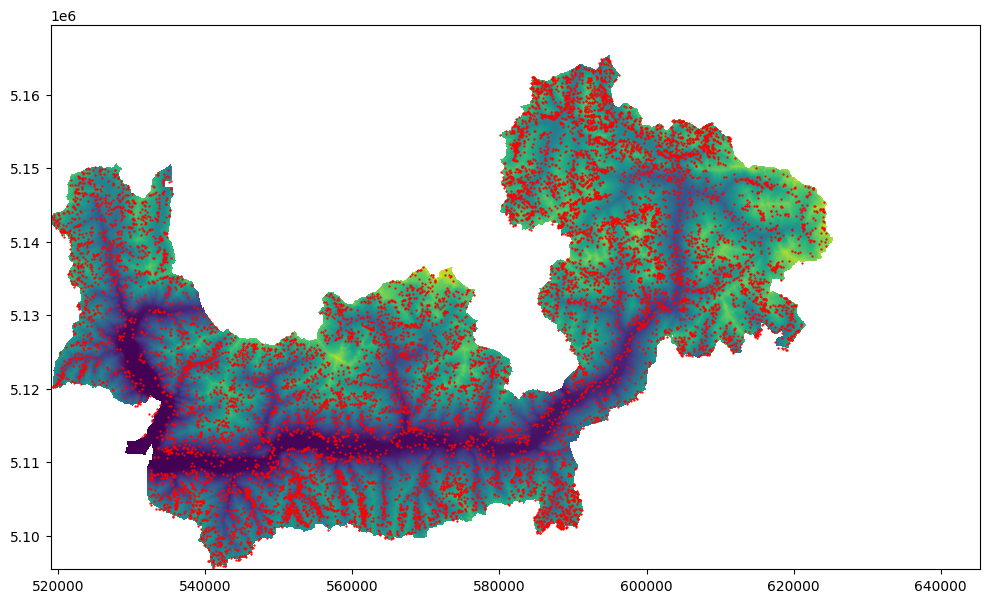

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
rasterio_show(tif_terrain, ax=ax)
gdf_train.plot(ax=ax, color="r", markersize=0.4)
plt.tight_layout()
plt.show()

Now we can begin to gather some [zonal statistics](https://geobgu.xyz/py/rasterio2.html#zonal-statistics). We'll be using `rasterstats` to get some statistics like min, max, mean, std, etc. But we'll also be creating a couple of custom features based exclusively on the terrain raster. We'll be calculating the slope of the terrain, the aspect of the slope, the terrain profile curvature (curvature of a land surface in the direction of the steepest slope; it quantifies how the slope changes along the slope direction) and the terrain plan curvature (curvature of a land surface perpendicular to the direction of the steepest slope; it quantifies how the slope changes in a direction orthogonal to the slope):

In [55]:
# calculate slope of the terrain (steeper slopes are more prone to landslides)
def _calculate_slope(area):
    grad_x, grad_y = np.gradient(area)
    slope_radians = np.arctan(np.sqrt(grad_x**2 + grad_y**2))
    slope_degrees = np.degrees(slope_radians)
    return slope_degrees

def calculate_slope_mean(area):
    degrees = _calculate_slope(area)
    return np.mean(degrees)

def calculate_slope_max(area):
    degrees = _calculate_slope(area)
    return np.max(degrees)

def calculate_slope_min(area):
    degrees = _calculate_slope(area)
    return np.min(degrees)

# calculate aspect of the slope (e.g. north-facing, south-facing)
def _calculate_aspect(area):
    grad_x, grad_y = np.gradient(area)
    aspect = np.arctan2(-grad_y, grad_x)
    aspect_degrees = np.degrees(aspect)
    return aspect_degrees

def calculate_aspect_mean(area):
    degrees = _calculate_aspect(area)
    return np.mean(degrees)

def calculate_aspect_max(area):
    degrees = _calculate_aspect(area)
    return np.max(degrees)

def calculate_aspect_min(area):
    degrees = _calculate_aspect(area)
    return np.min(degrees)

# calculate terrain profile curvature
def _calculate_curvature_terrain(area):
    grad_x, grad_y = np.gradient(area)
    grad_xx, grad_xy = np.gradient(grad_x)
    grad_yx, grad_yy = np.gradient(grad_y)
    profile_curvature = (-grad_xx * grad_yy + grad_xy**2) / (1 + grad_x**2 + grad_y**2)**1.5
    return profile_curvature

def calculate_curvature_terrain_mean(area):
    curvature = _calculate_curvature_terrain(area)
    return np.mean(curvature)

def calculate_curvature_terrain_max(area):
    curvature = _calculate_curvature_terrain(area)
    return np.max(curvature)

def calculate_curvature_terrain_min(area):
    curvature = _calculate_curvature_terrain(area)
    return np.min(curvature)

# calculate terrain plan curvature
def _calculate_curvature_plan(area):
    grad_x, grad_y = np.gradient(area)
    grad_xx, grad_xy = np.gradient(grad_x)
    grad_yx, grad_yy = np.gradient(grad_y)
    plan_curvature = (grad_xx + grad_yy) / (1 + grad_x**2 + grad_y**2)
    return plan_curvature

def calculate_curvature_plan_mean(area):
    curvature = _calculate_curvature_plan(area)
    return np.mean(curvature)

def calculate_curvature_plan_max(area):
    curvature = _calculate_curvature_plan(area)
    return np.max(curvature)

def calculate_curvature_plan_min(area):
    curvature = _calculate_curvature_plan(area)
    return np.min(curvature)

With these functions defined, we can now actually calculate the stats:

In [56]:
raster_stats = ["mean", "std", "min", "max", "sum", "median", "range", "percentile_10", "percentile_25", "percentile_75", "percentile_90"]

def engineer_raster_features(data, df_out, raster_stats, buffer_radii):
    out = []
    
    # iterate over all the radii
    for radius in tqdm(buffer_radii):
        buffered_data = data.copy()
        buffered_data.geometry = buffered_data.geometry.buffer(radius)

        # calculate terrain features
        print("calculating terrain features...")
        result_terrain = rasterstats.zonal_stats(
            buffered_data,
            tif_terrain.read(1),
            nodata=tif_terrain.nodata,
            affine=tif_terrain.transform,
            stats=raster_stats,
            add_stats={
                "slope_mean": calculate_slope_mean,
                "slope_max": calculate_slope_max,
                "slope_min": calculate_slope_min,
                "aspect_mean": calculate_aspect_mean,
                "aspect_max": calculate_aspect_max,
                "aspect_min": calculate_aspect_min,
                "curvature_terrain_mean": calculate_curvature_terrain_mean,
                "curvature_terrain_max": calculate_curvature_terrain_max,
                "curvature_terrain_min": calculate_curvature_terrain_min,
                "curvature_plan_mean": calculate_curvature_plan_mean,
                "curvature_plan_max": calculate_curvature_plan_max,
                "curvature_plan_min": calculate_curvature_plan_min,
            }
        )
        
        df_result_terrain = pd.DataFrame(result_terrain)
        df_result_terrain = df_result_terrain.rename(columns={i: f"terrain_{i}_radius{radius}" for i in df_result_terrain.columns})
        
        # calculate precipitation average features
        print("calculating precipitation average features...")
        result_precipitation_average = rasterstats.zonal_stats(
            buffered_data,
            tif_precipitation_average.read(1),
            nodata=tif_precipitation_average.nodata,
            affine=tif_precipitation_average.transform,
            stats=raster_stats,
        )
        
        df_result_precipitation_average = pd.DataFrame(result_precipitation_average)
        df_result_precipitation_average = df_result_precipitation_average.rename(columns={i: f"precipitation_average_{i}_radius{radius}" for i in df_result_precipitation_average.columns})
        
        # calculate precipitation 90th percentile features
        print("calculating precipitation 90th percentile features...")
        result_precipitation_90 = rasterstats.zonal_stats(
            buffered_data,
            tif_precipitation_90.read(1),
            nodata=tif_precipitation_90.nodata,
            affine=tif_precipitation_90.transform,
            stats=raster_stats,
        )
        
        df_result_precipitation_90 = pd.DataFrame(result_precipitation_90)
        df_result_precipitation_90 = df_result_precipitation_90.rename(columns={i: f"precipitation_90_{i}_radius{radius}" for i in df_result_precipitation_90.columns})
        
        # concat all raster features into one dataframe
        df_radius = pd.concat([df_result_terrain, df_result_precipitation_average, df_result_precipitation_90], axis=1)
        out.append(df_radius)
    
    # combine raster features with already existing features
    return pd.concat([df_out.reset_index(drop=True), pd.concat(out, axis=1)], axis=1) 
    
df_train = engineer_raster_features(gdf_train, df_train, raster_stats, buffer_radii)

  0%|          | 0/4 [00:00<?, ?it/s]

calculating terrain features...
calculating precipitation average features...
calculating precipitation 90th percentile features...


 25%|██▌       | 1/4 [01:56<05:48, 116.11s/it]

calculating terrain features...
calculating precipitation average features...
calculating precipitation 90th percentile features...


 50%|█████     | 2/4 [08:38<09:29, 284.53s/it]

calculating terrain features...
calculating precipitation average features...
calculating precipitation 90th percentile features...


 75%|███████▌  | 3/4 [26:38<10:47, 647.57s/it]

calculating terrain features...
calculating precipitation average features...
calculating precipitation 90th percentile features...


100%|██████████| 4/4 [2:24:01<00:00, 2160.28s/it]


And we're left with our final dataframe:

In [57]:
df_train.replace("--", np.nan, inplace=True) # in case there are some weird NaNs
df_train.head()

,Target,ID,geometry,road_type_radius100_road_intersection_length_radius100_Provincial,road_type_radius100_road_intersection_length_radius100_Secondary,river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Bocco (Torrente),river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Caldenno (Torrente),river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Cervio (Torrente),river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Finale (Torrente),river_Nome_Corpo_Idrico_radius100_river_intersection_length_radius100_Maroggia (Torrente),...,precipitation_90_max_radius2500,precipitation_90_mean_radius2500,precipitation_90_sum_radius2500,precipitation_90_std_radius2500,precipitation_90_median_radius2500,precipitation_90_range_radius2500,precipitation_90_percentile_10_radius2500,precipitation_90_percentile_25_radius2500,precipitation_90_percentile_75_radius2500,precipitation_90_percentile_90_radius2500
0,1.0,ID_000001,POINT (607174.0771399431 5124482.765102093),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.273365,0.262633,105000.695312,0.005134,0.263540,0.018512,0.257356,0.258516,0.265434,0.273365
1,1.0,ID_000002,POINT (611796.3079673459 5131481.270119999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.255143,0.225375,176729.703125,0.013406,0.226823,0.055613,0.202228,0.216630,0.232398,0.243465
2,1.0,ID_000003,POINT (613139.6068859898 5131228.87917981),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.243465,0.211788,166068.562500,0.014294,0.216630,0.058830,0.185901,0.202181,0.218499,0.229451
3,1.0,ID_000004,POINT (609347.4880599163 5131305.222482853),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.268181,0.244906,192039.718750,0.010324,0.243699,0.051551,0.229451,0.239693,0.252727,0.255143
4,1.0,ID_000005,POINT (611761.1333471948 5132712.759155421),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.275829,0.232239,182106.125000,0.016720,0.230993,0.076298,0.211381,0.218065,0.243465,0.255143


In [58]:
df_train.replace("--", np.nan, inplace=True) # in case there are some weird NaNs
df_train.to_csv("data/df_train.csv", index=False)

With **a LOT** of features!

# 4. Model development

With our features ready we can develop our model. We'll be using LightGBM due to its performance, speed and probability-based predictions. In order to achieve the best possible performance we'll be using Optuna to perform a hyperparameter search. Also, for a more robust evaluation, we'll be using cross-validation for training. We'll initially define our objective function (what we'll be optimizing on):

In [59]:
def objective(trial, X, y):
    # define search space
    param_grid = {
        # fixed params
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "objective": trial.suggest_categorical("objective", ["binary"]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "metric": trial.suggest_categorical("metric", ["binary_logloss"]),
        
        # searchable params
        "is_unbalance": trial.suggest_categorical("is_unbalance", ["false", "true"]), # automatically balance class weights
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 1000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0, step=0.1),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 5, step=1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0, step=0.1),
    }

    # initiate cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    # perform cross validation    
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # fit model
        model = lgb.LGBMClassifier(**param_grid)
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="binary_logloss",
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],
        )
        
        preds = model.predict_proba(X_val)
        cv_scores.append(log_loss(y_val, preds))
        
    return np.mean(cv_scores)

Now we can create an optuna study (https://www.nielsvandervelden.com/blog/2022-02-09-optuna-samplers/) and run it to optimize our model and find the best hyperparameters:

In [60]:
X = df_train.drop(["Target", "ID", "geometry"], axis=1)
y = df_train["Target"]

# arrange features for lgbm
for col in X.columns:
    X[col] = X[col].astype(float)
X = X.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))

study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=0), study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=100)

[I 2023-12-04 14:40:25,593] A new study created in memory with name: LGBM Classifier
[I 2023-12-04 14:42:01,922] Trial 0 finished with value: 0.19724543879053053 and parameters: {'n_estimators': 10000, 'objective': 'binary', 'verbose': -1, 'random_state': 42, 'metric': 'binary_logloss', 'is_unbalance': 'true', 'learning_rate': 0.18480137906077673, 'num_leaves': 1640, 'max_depth': 44, 'min_data_in_leaf': 620, 'lambda_l1': 45, 'lambda_l2': 90, 'min_gain_to_split': 14.45494140751544, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.19724543879053053.
[I 2023-12-04 14:43:42,613] Trial 1 finished with value: 0.17901069692629776 and parameters: {'n_estimators': 10000, 'objective': 'binary', 'verbose': -1, 'random_state': 42, 'metric': 'binary_logloss', 'is_unbalance': 'true', 'learning_rate': 0.03060045687738721, 'num_leaves': 280, 'max_depth': 4, 'min_data_in_leaf': 820, 'lambda_l1': 80, 'lambda_l2': 90, 'min_gain_to_split': 

Which will leave us with the following best value and best parameters:

In [61]:
print(f"best value: {study.best_value:.5f}")

print(f"best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

best value: 0.07869
best params:
	n_estimators: 10000
	objective: binary
	verbose: -1
	random_state: 42
	metric: binary_logloss
	is_unbalance: false
	learning_rate: 0.29173260941877943
	num_leaves: 1040
	max_depth: 20
	min_data_in_leaf: 20
	lambda_l1: 0
	lambda_l2: 35
	min_gain_to_split: 0.8067742150297849
	bagging_fraction: 0.30000000000000004
	bagging_freq: 0
	feature_fraction: 1.0


In [62]:
# encode dict into JSON
with open("data/best_params.json", "w") as fp:
    json.dump(study.best_params, fp)  

We can see that the LightGBM model coupled with the features we have end up being really robust, achieving a good performance even with non-optimal hyperparameter combinations. We can look more closely at the best hyperparameters by re-running the K-fold cross validation for the best hyperparameters:

In [63]:
# initiate cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# perform cross validation    
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # fit model
    model = lgb.LGBMClassifier(**study.best_params)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
    )
    
    # predict 
    preds = model.predict_proba(X_val)
    preds_binary = preds.argmax(axis=1)
    
    # get metrics
    print(f"=== fold {idx} ===")
    print(f"log loss: {log_loss(y_val, preds)}")
    print(f"accuracy: {accuracy_score(y_val, preds_binary)}")
    print(f"f1: {f1_score(y_val, preds_binary)}")

=== fold 0 ===
log loss: 0.07775589604921697
accuracy: 0.9670510708401977
f1: 0.9808978032473735
=== fold 1 ===
log loss: 0.07261014963596635
accuracy: 0.9703459637561779
f1: 0.982840800762631
=== fold 2 ===
log loss: 0.08164760774382376
accuracy: 0.9678747940691927
f1: 0.9814726840855108
=== fold 3 ===
log loss: 0.08857843123389177
accuracy: 0.96334431630972
f1: 0.9788246490601951
=== fold 4 ===
log loss: 0.07283971715404113
accuracy: 0.9715815485996705
f1: 0.9835596854896355


And as we can see, the model is quite robust! Now we can train our final model (the one we'll use for inference) with all of the available data (https://stats.stackexchange.com/a/52277):

In [64]:
X = df_train.drop(["Target", "ID", "geometry"], axis=1)
y = df_train["Target"]

# arrange features for lgbm
for col in X.columns:
    X[col] = X[col].astype(float)
X = X.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))

# fit model
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X, y)

model

LGBMClassifier(bagging_fraction=0.30000000000000004, bagging_freq=0,
               feature_fraction=1.0, is_unbalance='false', lambda_l1=0,
               lambda_l2=35, learning_rate=0.29173260941877943, max_depth=20,
               metric='binary_logloss', min_data_in_leaf=20,
               min_gain_to_split=0.8067742150297849, n_estimators=10000,
               num_leaves=1040, objective='binary', random_state=42,
               verbose=-1)

In [65]:
# save model
joblib.dump(model, "data/model.pkl")

['data/model.pkl']

# 5. Infering on the test data

Now that we have our final model ready we can perform inference on the test data. First, we just need to process the data. Since I'm running this on my personal computer, I process the test data in two batches (0-19999, 20000-39999) and then concatenate the batches to get the final test dataframe. Due to memory constraints I couldn't manage to run the for loop directly, so after running it initially as is I then ran it starting from `20000`:

In [54]:
# we process the data in 20000 row batches
#for i in range(0, len(gdf_test), 20000):
for i in range(20000, len(gdf_test), 20000):
    # segment geodataframe
    gdf_test_part = gdf_test.iloc[i:i+20000].copy()
    
    # create prepped dataframe
    df_test_prepped_part = dataprep_buffer(gdf_test_part, buffer_radii, train=False)
    df_test_prepped_part = dataprep_group(df_test_prepped_part, train=False)
    df_test_prepped_part = df_test_prepped_part.applymap(clean_list)
    
    # create dataframe with features
    df_test_part = df_test_prepped_part.copy()
    df_test_part = df_test_part.drop(list(df_test_part.columns)[2:], axis=1)
    df_test_part = engineer_gdf_features(df_test_part, df_test_prepped_part, feature_gdfs, buffer_radii)
    df_test_part = engineer_raster_features(gdf_test_part, df_test_part, raster_stats, buffer_radii)
    
    print(df_test_part.shape)
    
    df_test_part.replace("--", np.nan, inplace=True) # in case there are some weird NaNs
    df_test_part.to_csv(f"data/df_test_part{i}.csv", index=False)

preparing geodataframe for radius 100...
preparing geodataframe for radius 500...
preparing geodataframe for radius 1000...
preparing geodataframe for radius 2500...


  0%|          | 0/4 [00:00<?, ?it/s]

calculating density features...
calculating proportional numerical features...
calculating proportional categorical features...
calculating distance features...


 25%|██▌       | 1/4 [00:22<01:07, 22.46s/it]

calculating density features...
calculating proportional numerical features...
calculating proportional categorical features...
calculating distance features...


 50%|█████     | 2/4 [00:42<00:42, 21.18s/it]

calculating density features...
calculating proportional numerical features...
calculating proportional categorical features...
calculating distance features...


 75%|███████▌  | 3/4 [01:04<00:21, 21.31s/it]

calculating density features...
calculating proportional numerical features...
calculating proportional categorical features...
calculating distance features...


  0%|          | 0/4 [00:00<?, ?it/s]

calculating terrain features...
calculating precipitation average features...
calculating precipitation 90th percentile features...


 25%|██▌       | 1/4 [03:03<09:09, 183.19s/it]

calculating terrain features...
calculating precipitation average features...
calculating precipitation 90th percentile features...


 50%|█████     | 2/4 [12:48<13:59, 419.78s/it]

calculating terrain features...
calculating precipitation average features...
calculating precipitation 90th percentile features...


 75%|███████▌  | 3/4 [42:40<17:26, 1046.24s/it]

calculating terrain features...
calculating precipitation average features...
calculating precipitation 90th percentile features...


100%|██████████| 4/4 [3:51:29<00:00, 3472.28s/it]


(20000, 1734)


In [61]:
df_test_parts = []

for i in range(0, len(gdf_test), 20000):
    df_test_parts.append(pd.read_csv(f"data/df_test_part{i}.csv"))

df_test = pd.concat(df_test_parts).reset_index(drop=True)
print(df_test.shape)
df_test.to_csv("data/df_test.csv", index=False)

(40000, 1734)


And now we can use the model to finally get the predictions to the test data, which will be our submission for the competition:

In [63]:
model = joblib.load("data/model.pkl")
model

LGBMClassifier(bagging_fraction=0.30000000000000004, bagging_freq=0,
               feature_fraction=1.0, is_unbalance='false', lambda_l1=0,
               lambda_l2=35, learning_rate=0.29173260941877943, max_depth=20,
               metric='binary_logloss', min_data_in_leaf=20,
               min_gain_to_split=0.8067742150297849, n_estimators=10000,
               num_leaves=1040, objective='binary', random_state=42,
               verbose=-1)

In [67]:
# get test features
test_ids = df_test["ID"]
X_test = df_test.drop(["ID", "geometry"], axis=1)
X_test = X_test.astype(np.float64)

# predict on the test data with the trained model
test_predictions = model.predict(X_test)

# convert predicted probabilities to binary predictions
test_predictions_binary = [1 if pred >= 0.5 else 0 for pred in test_predictions]

# create a dataframe to store the results
results_df = pd.DataFrame({"ID": test_ids, "Target": test_predictions_binary})
results_df["Target"] = results_df["Target"].astype(int)

# save the results to a CSV file
results_df.to_csv("data/predictions.csv", index=False)

In [68]:
results_df

,ID,Target
0,ID_000001,1
1,ID_000002,1
2,ID_000003,1
3,ID_000004,1
4,ID_000005,1
...,...,...
39995,ID_039996,0
39996,ID_039997,0
39997,ID_039998,0
39998,ID_039999,1


In [69]:
results_df["Target"].value_counts()

Target
1    20687
0    19313
Name: count, dtype: int64

# 6. Getting probabilities for each

In order to be able to create a susceptibility map we're going to need to use our model to perform inference again, but this time getting the probabilities instead of just the binary outputs: 

In [70]:
test_probs = model.predict_proba(X_test)
predictions_prob = [i[1] for i in test_probs]

df_probs = pd.DataFrame({"ID": test_ids, "Target": predictions_prob})
df_probs["Target"] = df_probs["Target"]
df_probs.head()

,ID,Target
0,ID_000001,0.999054
1,ID_000002,0.998615
2,ID_000003,0.998127
3,ID_000004,0.998012
4,ID_000005,0.998129


We can merge this dataframe with the test geodataframe in order to get the coordinates of each item:

In [73]:
gdf_probs = gdf_test.merge(df_probs, on="ID")
gdf_probs.head()

,ID,geometry,Target
0,ID_000001,POINT (541862.336 5103652.266),0.999054
1,ID_000002,POINT (566456.496 5131798.978),0.998615
2,ID_000003,POINT (584598.972 5109016.391),0.998127
3,ID_000004,POINT (542414.162 5125941.301),0.998012
4,ID_000005,POINT (532099.144 5133370.588),0.998129


We can now transform our geodataframe into a raster file. This will allow us to have the points with the probabilities in their correct coordinates:

In [85]:
def rasterize_geodataframe(output_path, pixel_size=10):
    # extract coordinates and target variable from gdf
    geometry = gdf_probs['geometry']
    values = gdf_probs['Target']

    # create a bounding box around the points
    minx, miny, maxx, maxy = gdf_probs.geometry.total_bounds

    # calculate dimensions of the raster
    width = int((maxx - minx) / pixel_size)
    height = int((maxy - miny) / pixel_size)

    # create a raster profile
    transform = from_origin(minx, maxy, pixel_size, pixel_size)
    profile = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': rasterio.float32,
        'width': width,
        'height': height,
        'crs': gdf_probs.crs,
        'transform': transform,
        'compress': 'lzw',
        'nodata': float('nan')
    }

    # create a raster file
    with rasterio.open(output_path, 'w', **profile) as dst:
        # rasterize points onto the raster
        rasterized = rasterio.features.rasterize(
            zip(geometry, values),
            out_shape=(height, width),
            transform=transform,
            fill=float('nan')
        )

        # write rasterized data to the geotiff
        dst.write(rasterized, 1)

Now, we can take these points that are in the raster and created a "windowed" raster, which will be our probability map. Basically, we're segmenting the rasterized probability dataframe into equally sized windows; these are equivalent to pixels in the final susceptibility map. The value of each window is calculated as being the mean of the values of all points located said window:

In [86]:
def create_windowed_geotiff(input_path, output_path, window_size):
    with rasterio.open(input_path) as src:
        data = src.read(1)
        profile = src.profile
        nodata = src.nodatavals[0]

        # calculate number of windows in each dimension
        num_windows_rows = int(np.ceil(src.height / window_size))
        num_windows_cols = int(np.ceil(src.width / window_size))

        # create empty array for output data
        output_data = np.full_like(data, fill_value=nodata, dtype=np.float32)

        # iterate over windows
        for i in range(num_windows_rows):
            for j in range(num_windows_cols):
                # define the window coordinates
                row_start = i * window_size
                row_end = min((i + 1) * window_size, src.height)
                col_start = j * window_size
                col_end = min((j + 1) * window_size, src.width)

                # extract window from rasterized gdf
                window_data = data[row_start:row_end, col_start:col_end]

                # check window contains valid data
                if not np.all(window_data == nodata):
                    # get mean of all the points in the window
                    window_mean = np.nanmean(window_data)

                    # place the mean value in the corresponding position in the output array
                    output_data[row_start:row_end, col_start:col_end] = window_mean

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(output_data, 1)

And now we can combine these two functions to create different probability susceptibility maps:

In [93]:
def create_susceptibility_map(output_path, window_size, pixel_size=10):
    intermediate_path = os.path.join(output_path, f"tmp_rasterized_w{window_size}.tif")
    
    rasterize_geodataframe(intermediate_path, pixel_size)
    
    output_path = os.path.join(output_path, f"susceptibility_probs_w{window_size}.tif")
    create_windowed_geotiff(intermediate_path, output_path, window_size)
    
create_susceptibility_map("data/", window_size=100)
create_susceptibility_map("data/", window_size=250)

/var/folders/zk/x29qw4cj2m745bkyfyb7c52r0000gn/T/ipykernel_12149/2769821924.py:29: RuntimeWarning: Mean of empty slice
  window_mean = np.nanmean(window_data)
/var/folders/zk/x29qw4cj2m745bkyfyb7c52r0000gn/T/ipykernel_12149/2769821924.py:29: RuntimeWarning: Mean of empty slice
  window_mean = np.nanmean(window_data)


We can see for example how the window of size 250 looks like:

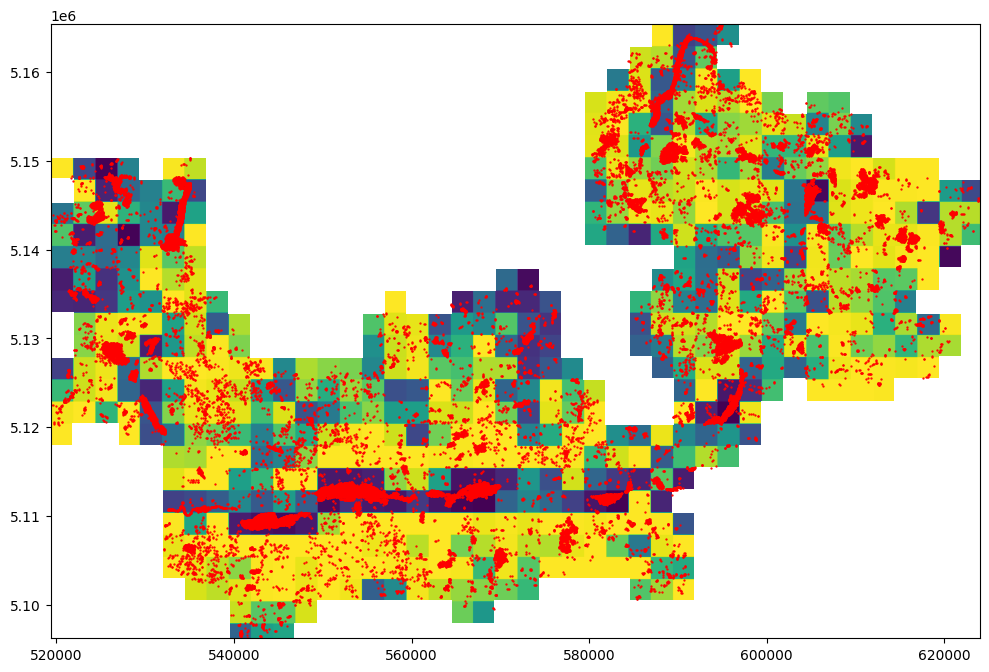

In [94]:
susceptibility_map = rasterio.open("data/susceptibility_probs_w250.tif")

fig, ax = plt.subplots(figsize=(10,10))
rasterio_show(susceptibility_map, ax=ax)
gdf_probs.plot(ax=ax, color="r", markersize=0.4)
plt.tight_layout()
plt.show()

As another step, we can follow literature (Van Den Eeckhaut, M., Hervás, J., Jaedicke, C., Malet, J. P., Montanarella, L., Nadim, F. 2012. Statistical modelling of Europe-wide landslide susceptibility using limited landslide inventory data. Landslides, 9, 357-369. DOI: 10.1007/s10346-011-0299-z) and consider different classes for the susceptibility based on the probability of a landslide happening in the area, where, with $p$ being the probability, $0 \leq p < 0.20$ is very low, $0.20 \leq p < 0.45$ is low , $0.45 \leq p< 0.55$ is moderate, $0.55 \leq p< 0.80$ is high and $0.80 \leq p< 1$ is very high.